# Data Cleaning and Feature Engineering

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings

In [2]:
#US Open point-by-point
pts = pd.read_csv('./data/2019-usopen-points.csv')

In [3]:
pts.head()

,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,P2TurningPoint,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2019-usopen-1101,0:00:00,1,0,0,0,1,0,0X,0,...,NaN,0,0,0,0.000,0.000,0,NaN,NaN,NaN
1,2019-usopen-1101,0:00:00,1,0,0,0,1,0,0Y,0,...,NaN,0,0,0,0.000,0.000,0,NaN,NaN,NaN
2,2019-usopen-1101,0:00:00,1,0,0,0,1,0,1,1,...,NaN,2,0,0,29.095,33.480,9,BC,NCTL,D
3,2019-usopen-1101,0:00:55,1,0,0,0,1,0,2,2,...,NaN,0,0,0,0.577,0.510,0,NaN,NaN,NaN
4,2019-usopen-1101,0:01:22,1,0,0,0,1,0,3,1,...,NaN,1,0,0,14.642,8.791,5,C,NCTL,ND


In [4]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47893 entries, 0 to 47892
Data columns (total 65 columns):
match_id              47893 non-null object
ElapsedTime           47893 non-null object
SetNo                 47893 non-null int64
P1GamesWon            47893 non-null int64
P2GamesWon            47893 non-null int64
SetWinner             47893 non-null int64
GameNo                47893 non-null int64
GameWinner            47893 non-null int64
PointNumber           47893 non-null object
PointWinner           47893 non-null int64
PointServer           47893 non-null int64
Speed_KMH             47893 non-null int64
Rally                 0 non-null float64
P1Score               47893 non-null object
P2Score               47893 non-null object
P1Momentum            47893 non-null int64
P2Momentum            47893 non-null int64
P1PointsWon           47893 non-null int64
P2PointsWon           47893 non-null int64
P1Ace                 47893 non-null int64
P2Ace                 47893 

In [5]:
#columns where all values are null
cols_to_drop = ['Serve_Direction','Winner_FH','Winner_BH','ServingTo',
                'P1TurningPoint','P2TurningPoint','P1FirstSrvIn',
                'P2FirstSrvIn','P1FirstSrvWon','P2FirstSrvWon',
               'P1SecondSrvIn','P2SecondSrvIn','P1SecondSrvWon',
               'P2SecondSrvWon','P1ForcedError','P2ForcedError',
               'Rally',]

In [6]:
#drop columns where all values are null
for col in cols_to_drop:
    pts = pts.drop(col, axis=1)

In [7]:
#drop rows where no points are played
pts = pts[pts['PointWinner'] != 0]

In [8]:
#create unique id based on point number AND match id
pts['match_id_simplified'] = [str(i.split('-')[2]) for i in np.array(pts.match_id)]
type(pts.match_id_simplified)
pts['unique_id'] = np.array(pts.match_id_simplified.values)+"-"+np.array(pts.PointNumber.values)

In [9]:
# if double fault set serve number to 2 
# (that is the information we would have about the point before the 2nd serve)
pts['ServeNumber']=[2 if value==0 else value for value in pts['ServeNumber']]

In [10]:
#elminate matches where there is no information other than who wins each point
matches_to_eliminate = []
for group in set(pts['match_id_simplified']):
    zeroes = pts[pts['Speed_MPH']==0].groupby('match_id_simplified').groups[group]
    if len(zeroes) > 55:
        matches_to_eliminate.append(group)


In [11]:
for group in matches_to_eliminate:
    pts = pts[pts['match_id_simplified'] != group]

In [12]:
# getting information about gender of players from each match from other dataframe
matches = pd.read_csv('./data/2019-usopen-matches.csv')

In [13]:
#adding gender feature
pts['gender'] = ['W' if int(m_id)>2100 else 'M' for m_id in pts['match_id_simplified']]

In [14]:
#setting index to unique id
pts_1 = pts.set_index('unique_id')

In [18]:
# function to group by match_id and 2 other columns in order to calculate the 
# stats for a given point without including info about that point
# but keeping unique_id of the associated point 

def get_rolling_avg(col1, col2, col3, target_col, dataframe, d):
    col1_unique_vals = set(dataframe[col1])
    col2_unique_vals = set(dataframe[col2])
    col3_unique_vals = set(dataframe[col3])
    
    master_master_series = pd.Series()
    for a in col1_unique_vals:
        for b in col2_unique_vals:
            for c in col3_unique_vals:
                df_grouped = dataframe.groupby([col1,col2,col3]).get_group((a,b,c))
                avg_speeds_series = (pd.Series([df_grouped[df_grouped[target_col]!=0]
                                                [target_col].iloc[d:i].mean()
                                                for i in range(len(df_grouped))], 
                                                  index = df_grouped.index))
                master_master_series = pd.concat([master_master_series, avg_speeds_series], axis=0)
    
    return master_master_series
        

In [19]:
# function to calculate stats for a given point for the preceding 5 points that are relevant

def get_avg_last_5(col1, col2, col3, target_col, dataframe):
    col1_unique_vals = set(dataframe[col1])
    col2_unique_vals = set(dataframe[col2])
    col3_unique_vals = set(dataframe[col3])
    
    master_master_series = pd.Series()
    for a in col1_unique_vals:
        for b in col2_unique_vals:
            for c in col3_unique_vals:
                df_grouped = dataframe.groupby([col1,col2,col3]).get_group((a,b,c))
                avg_speeds_series = (pd.Series([df_grouped[df_grouped[target_col]!=0]
                                                [target_col].iloc[i-5:i].mean()
                                                for i in range(len(df_grouped))], 
                                                  index = df_grouped.index))
                master_master_series = pd.concat([master_master_series, avg_speeds_series], axis=0)
    
    return master_master_series

In [20]:
#avg serve speed of relevent preceding points, grouped by match, who is serving, and the Serve Number
pts_1['prior_avg_speed']=get_rolling_avg('match_id_simplified', 
                                            'PointServer', 'ServeNumber', 
                                            'Speed_MPH', pts_1, 0)

In [21]:
#avg serve speed of prior 5 points, grouped by match, who is serving, and the Serve Number
pts_1['last_5_avg_speed']=get_avg_last_5('match_id_simplified', 
                                            'PointServer', 'ServeNumber', 
                                            'Speed_MPH', pts_1)

In [23]:
pts_1['Ace'] = pts_1['P1Ace']+pts_1['P2Ace']


,PointNumber,PointWinner,PointServer,ServeNumber,Speed_MPH,prior_avg_speed,last_5_avg_speed,P1PointsWon,P1Ace,P2Ace,Ace
unique_id,,,,,,,,,,,
1101-1,1,1,1,2,82,NaN,NaN,1,0,0,0
1101-2,2,2,1,2,0,82.000000,NaN,1,0,0,0
1101-3,3,1,1,1,119,NaN,NaN,2,0,0,0
1101-4,4,2,1,1,117,119.000000,NaN,2,0,0,0
1101-5,5,1,1,2,102,92.000000,NaN,3,0,0,0
1101-6,6,1,1,1,118,118.000000,NaN,4,0,0,0
1101-7,7,2,2,1,108,NaN,NaN,4,0,0,0
1101-8,8,1,2,1,108,108.000000,NaN,5,0,0,0
1101-9,9,1,2,2,97,NaN,NaN,6,0,0,0


In [24]:
def get_ace_rate(col1, col2, target_col, dataframe):
    col1_unique_vals = set(dataframe[col1])
    col2_unique_vals = set(dataframe[col2])
    
    master_master_series = pd.Series()
    for a in col1_unique_vals:
        for b in col2_unique_vals:
            try:
                df_grouped = dataframe.groupby([col1,col2]).get_group((a,b))
                avg_speeds_series = (pd.Series([df_grouped[target_col].iloc[:i].mean()
                                                for i in range(len(df_grouped))], 
                                                  index = df_grouped.index))
                master_master_series = pd.concat([master_master_series, avg_speeds_series], axis=0)
            except:
                pass

    return master_master_series
        

In [25]:
pts_1['AceRate']=get_ace_rate('match_id_simplified', 'PointServer', 'Ace', pts_1)

In [26]:
def get_ace_rate_last_5(col1, col2, target_col, dataframe):
    col1_unique_vals = set(dataframe[col1])
    col2_unique_vals = set(dataframe[col2])
    
    master_master_series = pd.Series()
    for a in col1_unique_vals:
        for b in col2_unique_vals:
            try:
                df_grouped = dataframe.groupby([col1,col2]).get_group((a,b))
                avg_speeds_series = (pd.Series([df_grouped[target_col].iloc[i-5:i].mean()
                                                for i in range(len(df_grouped))], 
                                              index = df_grouped.index))
                master_master_series = pd.concat([master_master_series, avg_speeds_series], axis=0)
            except:
                pass
             
    return master_master_series


In [27]:
pts_1['DoubleFault'] = pts_1['P1DoubleFault']+pts_1['P2DoubleFault']

In [28]:
pts_1['AceRate_last_5']=get_ace_rate_last_5('match_id_simplified', 'PointServer', 'Ace', pts_1)

In [29]:
pts_1['DF_last_5']=get_ace_rate_last_5('match_id_simplified', 'PointServer', 'DoubleFault', pts_1)
pts_1['DoubleFault_rate']=get_ace_rate('match_id_simplified', 'PointServer', 'DoubleFault', pts_1)

In [30]:
def get_unferr_rate(col1, target_col, dataframe):
    col1_unique_vals = set(dataframe[col1])
    
    master_master_series = pd.Series()
    
    for a in col1_unique_vals:
        try:
            df_grouped = dataframe.groupby([col1]).get_group((a))
            avg_unferr_series = (pd.Series([df_grouped[target_col].iloc[:i].mean()
                                            for i in range(len(df_grouped))], 
                                              index = df_grouped.index))
            master_master_series = pd.concat([master_master_series, avg_unferr_series], axis=0)
        except:
            pass

    return master_master_series

In [31]:
def get_unferr_rate_last_5(col1, target_col, dataframe):
    col1_unique_vals = set(dataframe[col1])
    
    master_master_series = pd.Series()

    for a in col1_unique_vals:
        try:
            df_grouped = dataframe.groupby([col1]).get_group((a))
            avg_unferr_series = (pd.Series([df_grouped[target_col].iloc[i-5:i].mean()
                                                for i in range(len(df_grouped))], 
                                                  index = df_grouped.index))
            master_master_series = pd.concat([master_master_series, avg_unferr_series], axis=0)
        except:
            pass
    return master_master_series

In [32]:
pts_1.iloc[2137-4]['P1NetPointWon']

0

In [33]:
pts_1['P1UnfErrRate'] = get_unferr_rate('match_id_simplified','P1UnfErr', pts_1)
pts_1['P2UnfErrRate'] = get_unferr_rate('match_id_simplified','P1UnfErr', pts_1)
pts_1['P1UnfErr_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1UnfErr', pts_1)
pts_1['P2UnfErr_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1UnfErr', pts_1)
pts_1['P1AceRate'] = get_unferr_rate('match_id_simplified', 'P1Ace', pts_1)
pts_1['P2AceRate'] = get_unferr_rate('match_id_simplified', 'P2Ace', pts_1)
pts_1['P1AceRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1Ace', pts_1)
pts_1['P2AceRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1Ace', pts_1)
pts_1['P1NetRate'] = get_unferr_rate('match_id_simplified', 'P1NetPoint', pts_1)
pts_1['P2NetRate'] = get_unferr_rate('match_id_simplified', 'P2NetPoint', pts_1)
pts_1['P1NetRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1NetPoint', pts_1)
pts_1['P2NetRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P2NetPoint', pts_1)

pts_1['P1BreakRate'] = get_unferr_rate('match_id_simplified', 'P1BreakPoint', pts_1)
pts_1['P2BreakRate'] = get_unferr_rate('match_id_simplified', 'P2BreakPoint', pts_1)
pts_1['P1BreakRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1BreakPoint', pts_1)
pts_1['P2BreakRate_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P2BreakPoint', pts_1)
pts_1['P1BreakPointWinRate']=get_ace_rate('match_id_simplified', 'P1BreakPoint', 'P1BreakPointWon', pts_1)
pts_1['P2BreakPointWinRate']=get_ace_rate('match_id_simplified', 'P2BreakPoint', 'P2BreakPointWon', pts_1)
pts_1['P1BreakPointWinRate_last5']=get_ace_rate_last_5('match_id_simplified', 'P1BreakPoint', 
                                                       'P1BreakPointWon', pts_1)
pts_1['P2BreakPointWinRate_last5']=get_ace_rate_last_5('match_id_simplified', 'P2BreakPoint', 
                                                       'P2BreakPointWon', pts_1)

pts_1['P1AvgDistanceRun'] = get_unferr_rate('match_id_simplified', 'P1DistanceRun', pts_1)*3.28084
pts_1['P2AvgDistanceRun'] = get_unferr_rate('match_id_simplified', 'P2DistanceRun', pts_1)*3.28084
pts_1['P1DistRun_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1DistanceRun', pts_1)*3.28084
pts_1['P2DistRun_last5'] = get_unferr_rate_last_5('match_id_simplified', 'P1DistanceRun', pts_1)*3.28084

pts_1['AvgRallyCount'] = get_unferr_rate('match_id_simplified', 'RallyCount', pts_1)
pts_1['last_5_RallyCount'] = get_unferr_rate_last_5('match_id_simplified', 'RallyCount', pts_1)

In [34]:
pts_1['P1NetPointWinRate']=get_ace_rate('match_id_simplified', 'P1NetPoint', 'P1NetPointWon', pts_1)
pts_1['P2NetPointWinRate']=get_ace_rate('match_id_simplified', 'P2NetPoint', 'P2NetPointWon', pts_1)
pts_1['P1NetPointWinRate_last5']=get_ace_rate_last_5('match_id_simplified', 'P1NetPoint', 'P1NetPointWon', pts_1)
pts_1['P2NetPointWinRate_last5']=get_ace_rate_last_5('match_id_simplified', 'P2NetPoint', 'P2NetPointWon', pts_1)


In [35]:
P1_Score = []
for score in pts_1['P1Score']:
    if score == '15':
        a = int(1)
    elif score == '30':
        a = int(2)
    elif score == '40':
        a = int(3)
    elif score == 'AD':
        a = int(4)
    else:
        a = int(score)
    P1_Score.append(a-1)

In [36]:
P2_Score = []
for score in pts_1['P1Score']:
    if score == '15':
        a = int(1)
    elif score == '30':
        a = int(2)
    elif score == '40':
        a = int(3)
    elif score == 'AD':
        a = int(4)
    else:
        a = int(score)
    P2_Score.append(a-1)

In [37]:
pts_1['P1_Score'] = P1_Score
pts_1['P2_Score'] = P2_Score

In [38]:
pts_1['P1PointsWon'] = [int(point) - 1 if int(point)>=1 else 0 for point in pts_1['P1PointsWon']]
pts_1['P2PointsWon'] = [int(point) - 1 if int(point)>=1 else 0 for point in pts_1['P2PointsWon']]

In [39]:
pts_1['P1GamesWon'] = [pts_1['P1GamesWon'].iloc[i-1] 
                       if i>=1 else 0 for i,game in enumerate(pts_1['P1GamesWon'])]
pts_1['P2GamesWon'] = [pts_1['P2GamesWon'].iloc[i-1] 
                       if i>=1 else 0 for i,game in enumerate(pts_1['P2GamesWon'])]

In [40]:
pts_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28677 entries, 1101-1 to 2701-145
Data columns (total 90 columns):
match_id                     28677 non-null object
ElapsedTime                  28677 non-null object
SetNo                        28677 non-null int64
P1GamesWon                   28677 non-null int64
P2GamesWon                   28677 non-null int64
SetWinner                    28677 non-null int64
GameNo                       28677 non-null int64
GameWinner                   28677 non-null int64
PointNumber                  28677 non-null object
PointWinner                  28677 non-null int64
PointServer                  28677 non-null int64
Speed_KMH                    28677 non-null int64
P1Score                      28677 non-null object
P2Score                      28677 non-null object
P1Momentum                   28677 non-null int64
P2Momentum                   28677 non-null int64
P1PointsWon                  28677 non-null int64
P2PointsWon                  2867

In [41]:
#drop old deterministic columns 
cols_to_drop1 = ['ElapsedTime','SetWinner','GameWinner','Speed_KMH','P1Score','P2Score',
                'P1Momentum','P2Momentum','P1Ace','P2Ace','P1Winner','P2Winner','P1DoubleFault',
                'P2DoubleFault','P1UnfErr','P2UnfErr','P1NetPoint','P2NetPoint','P1BreakPointWon',
                'P2BreakPointWon','History','Speed_MPH','P1BreakPointMissed','P2BreakPointMissed',
                'ServeIndicator','WinnerType','WinnerShotType','P1DistanceRun','P2DistanceRun',
                'RallyCount','ServeWidth','ServeDepth','ReturnDepth','Ace','DoubleFault',
                 'P1NetPointWon','P2NetPointWon']
final_pts = pts_1
for col in cols_to_drop1:
    final_pts = final_pts.drop(col, axis=1)

In [43]:
final_pts_1 = final_pts.dropna()

In [44]:
final_pts_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22977 entries, 1101-14 to 2701-144
Data columns (total 53 columns):
match_id                     22977 non-null object
SetNo                        22977 non-null int64
P1GamesWon                   22977 non-null int64
P2GamesWon                   22977 non-null int64
GameNo                       22977 non-null int64
PointNumber                  22977 non-null object
PointWinner                  22977 non-null int64
PointServer                  22977 non-null int64
P1PointsWon                  22977 non-null int64
P2PointsWon                  22977 non-null int64
P1BreakPoint                 22977 non-null int64
P2BreakPoint                 22977 non-null int64
ServeNumber                  22977 non-null int64
match_id_simplified          22977 non-null object
gender                       22977 non-null object
prior_avg_speed              22977 non-null float64
last_5_avg_speed             22977 non-null float64
AceRate                      

In [279]:
final_pts_1.head()

,match_id,SetNo,P1GamesWon,P2GamesWon,GameNo,PointNumber,PointWinner,PointServer,P1PointsWon,P2PointsWon,...,P1DistRun_last5,P2DistRun_last5,AvgRallyCount,last_5_RallyCount,P1NetPointWinRate,P2NetPointWinRate,P1NetPointWinRate_last5,P2NetPointWinRate_last5,P1_Score,P2_Score
unique_id,,,,,,,,,,,,,,,,,,,,,
1101-14,2019-usopen-1101,1,1,0,2,14,1,2,7,5,...,69.938979,69.938979,5.076923,7.4,0.0,0.0,0.0,0.0,2,2
1101-17,2019-usopen-1101,1,1,0,2,17,1,2,9,6,...,87.466538,87.466538,5.812500,8.2,0.0,0.0,0.0,0.0,3,3
1101-19,2019-usopen-1101,1,1,0,2,19,0,2,9,8,...,106.362864,106.362864,6.444444,10.0,0.0,0.0,0.0,0.0,2,2
1101-21,2019-usopen-1101,1,1,0,2,21,0,2,10,9,...,94.158139,94.158139,6.050000,8.4,0.0,0.0,0.0,0.0,2,2
1101-22,2019-usopen-1101,1,1,0,2,22,0,2,10,10,...,88.795278,88.795278,6.380952,8.2,0.0,0.0,0.0,0.0,-1,-1


In [405]:
final_pts_1.to_csv('updated_final_pts')

# EDA

Target Variable
PointWinner
0    11415
1    11562
Name: PointWinner, dtype: int64


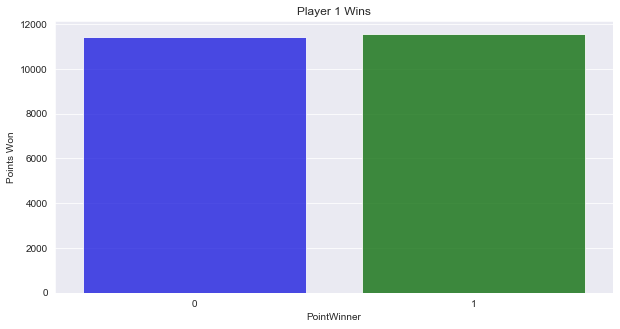

In [266]:
# check for class imbalance

print('Target Variable')
print(final_pts_1.groupby(['PointWinner']).PointWinner.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(final_pts_1['PointWinner'], alpha =.80, palette= ['blue','green'])
plt.title('Player 1 Wins')
plt.ylabel('Points Won')
plt.show()

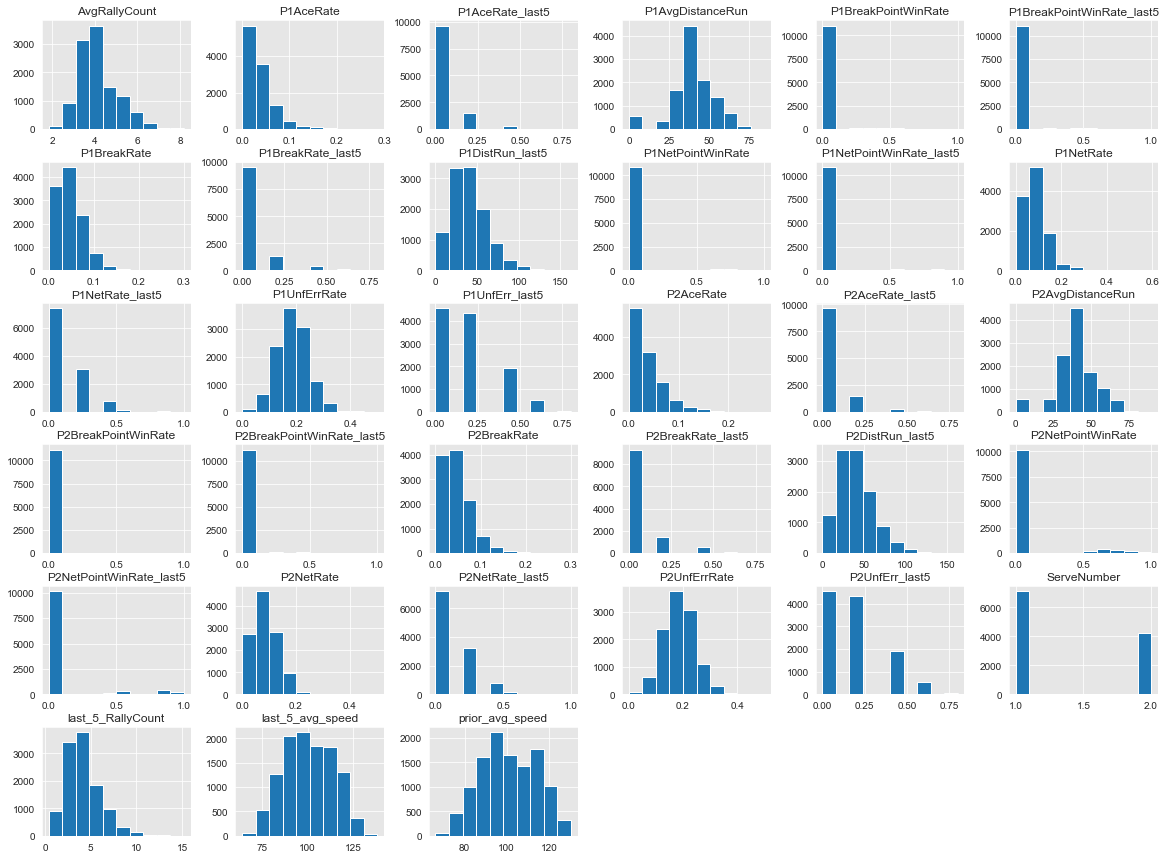

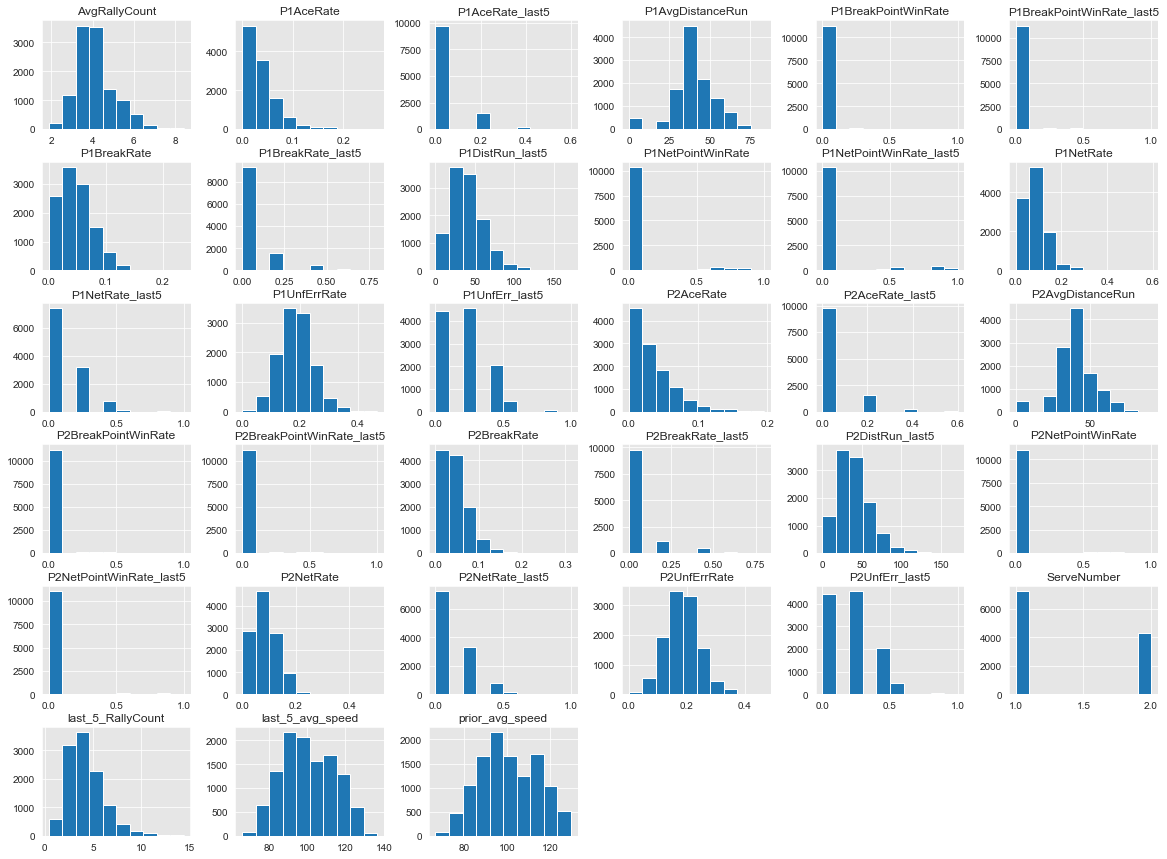

In [343]:
to_graph = continuous.drop(['AceRate','AceRate_last_5','DF_last_5','DoubleFault_rate',
                           'GameNo','P1GamesWon','P2GamesWon','P1_Score','P2_Score',
                           'P1PointsWon','P2PointsWon','PointNumber','SetNo'], axis=1)
to_graph.groupby(['PointWinner']).hist(figsize  = [20,15]);

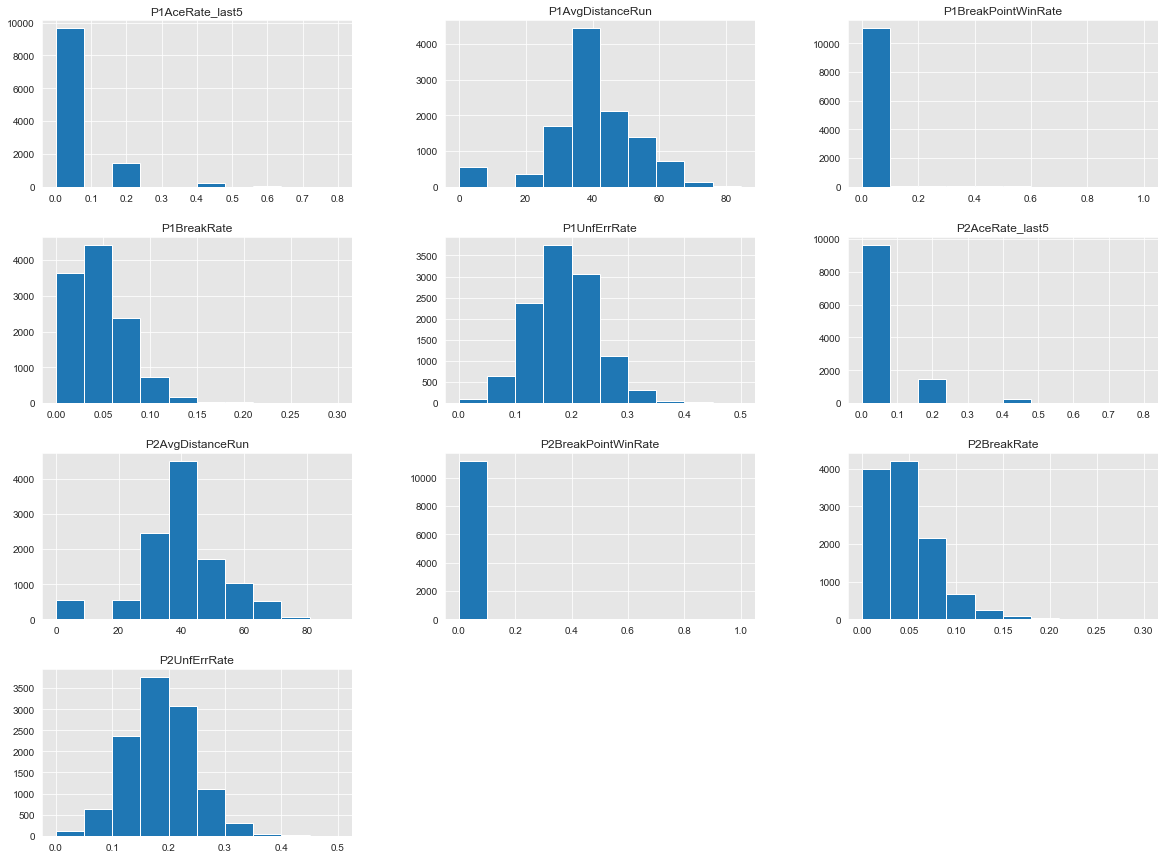

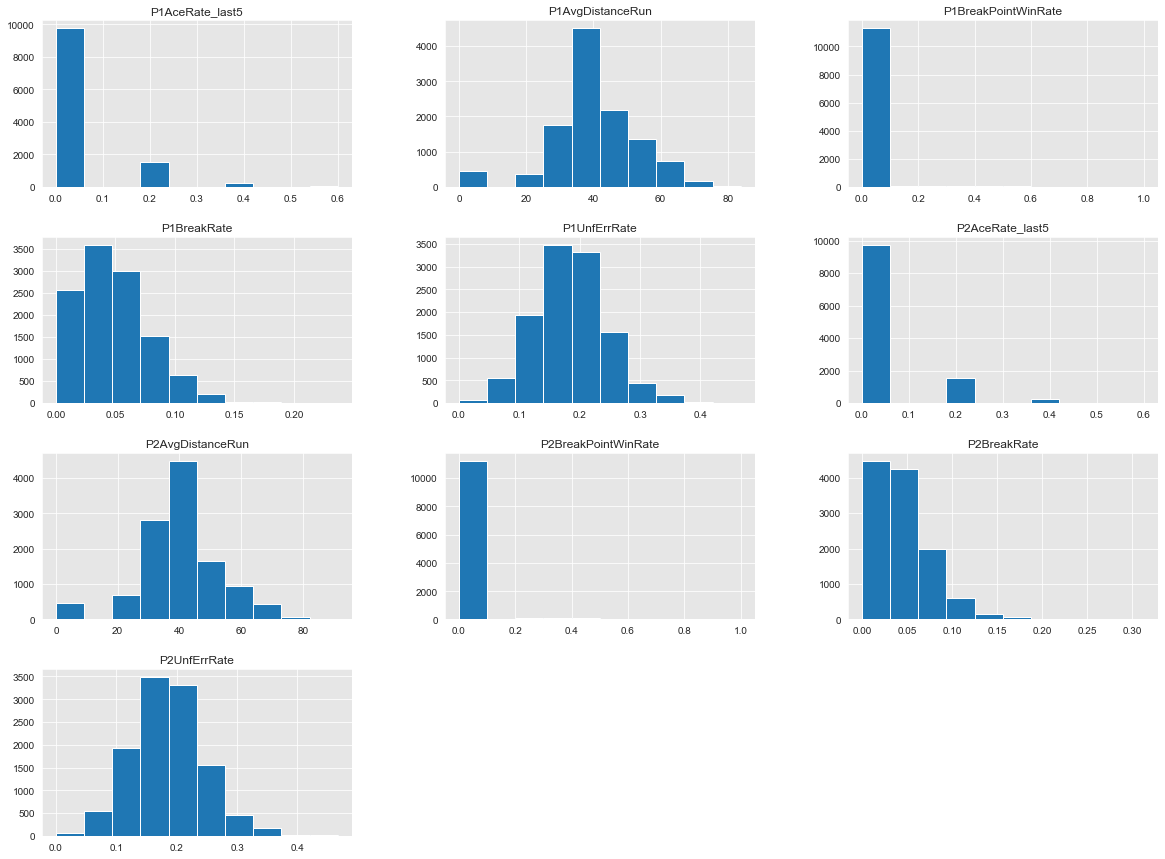

In [348]:
to_graph[['PointWinner','P1BreakRate','P2BreakRate',
        'P1BreakPointWinRate','P2BreakPointWinRate',
        'P1UnfErrRate','P2UnfErrRate','P1AceRate_last5',
          'P2AceRate_last5','P1AvgDistanceRun',
          'P2AvgDistanceRun']].groupby(['PointWinner']).hist(figsize  = [20,15]);

In [356]:
means = to_graph[['PointWinner','P1BreakRate','P2BreakRate',
        'P1BreakPointWinRate','P2BreakPointWinRate',
        'P1UnfErrRate','P2UnfErrRate','P1AceRate_last5',
          'P2AceRate_last5','P1AvgDistanceRun',
          'P2AvgDistanceRun']].groupby(['PointWinner']).agg(np.mean)
means.head()
means.iloc[0:2]

,P1BreakRate,P2BreakRate,P1BreakPointWinRate,P2BreakPointWinRate,P1UnfErrRate,P2UnfErrRate,P1AceRate_last5,P2AceRate_last5,P1AvgDistanceRun,P2AvgDistanceRun
PointWinner,,,,,,,,,,
0,0.046717,0.045175,0.012360,0.008059,0.185670,0.185670,0.036916,0.036916,39.761735,40.047839
1,0.048119,0.043546,0.009409,0.011912,0.185302,0.185302,0.036793,0.036793,39.870373,40.175307


In [361]:
means_BP = to_graph[['PointWinner','P1BreakRate','P2BreakRate',
        'P1BreakPointWinRate','P2BreakPointWinRate']].groupby(['PointWinner']).agg(np.mean)
means_BP.head()


,P1BreakRate,P2BreakRate,P1BreakPointWinRate,P2BreakPointWinRate
PointWinner,,,,
0,0.046717,0.045175,0.012360,0.008059
1,0.048119,0.043546,0.009409,0.011912
